Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "BoyanMihaylov"

# Game theory in Python

In this notebook we reiterate the topics touched in the lecture, get used to the basic concepts of game theory, as well as how to implement it using Python. The notebook contains four parts:
- The (iterated) prisonners dilemma,
- Evolutionary hawk-dove game,
- Calculating Nash equilibria,
- Calculating dominant strategies.

First we install the package axelrod and test if we can import it.

In [6]:
from IPython.display import clear_output
import axelrod
import numpy as np
clear_output()
print("Everything imported!")

Everything imported!


### Effective Choice in the Prisoners Dilemma
In the first part of the notebook we will recreate the research originally done by Axelrod. Start with reading his [paper](./AxelrodEffectiveChoiceinthePrisonersDilemma.pdf) (Its the pdf in the same folder as the notebook, open it outside notebook environment)
.

Fortunately for us, the prisoners dilemma is already implemented as a Python package, called Axelrod. Take a look at their [GitHub page](https://github.com/Axelrod-Python/Axelrod) and their [readthedocs](https://axelrod.readthedocs.io/en/stable/).

<table>
    <tr>
        <td></td>
        <td></td>
        <td>Player B</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>C</td>
        <td>D</td>
    </tr>
    <tr>
        <td>Player A</td>
        <td>C</td>
        <td>(3, 3)</td>
        <td>(0, 5)</td>
    </tr>
    <tr>
        <td></td>
        <td>D</td>
        <td>(5, 0)</td>
        <td>(1, 1)</td>
    </tr>
</table>


To get used to the workflow of axelrod we begin by implementing a simple match. In this match we will want to see the result of a prisonners dilemma between a so-called cooperator strategy, and a so-called alternator strategy. We already implemented this for you:

In [3]:
import axelrod as axl
# make a tuple, called players, containing Cooperator and an Alternator
players = (axl.Cooperator(), axl.Alternator())

# let them play
match = axl.Match(players, turns=5)
turns = match.play()

# extract the final_score and winner from the match
final_score = match.final_score()
winner = match.winner()

print(f'turns: \t\t{turns}')
print(f'final_score: \t{final_score}')
print(f'winner: \t{winner}')

turns: 		[(C, C), (C, D), (C, C), (C, D), (C, C)]
final_score: 	(9, 19)
winner: 	Alternator


Axelrod 'organised' a tournament with many players. Here we will recreate the (first) tournament with axelrod. Take a look at [which strategies of the (first) tournament are implemented in axelrod](https://axelrod.readthedocs.io/en/stable/discussion/overview_of_past_tournaments.html#axelrod-s-first-tournament), and take a look [how to implement a tournament](https://axelrod.readthedocs.io/en/stable/tutorials/new_to_game_theory_and_or_python/index.html).

[Tit For Tat, First by Tideman and Chieruzzi: (D, D), First by Nydegger, First by Grofman, First by Shubik, First by Stein and Rapoport: 0.05: (D, D), Grudger, First by Davis: 10, First by Graaskamp: 0.05, First by Downing, First by Feld: 1.0, 0.5, 200, First by Joss: 0.9, First by Tullock, First by Anonymous, Random: 0.5]


Analysing:   0%|          | 0/25 [00:00<?, ?it/s]c:\Users\mihbo\anaconda3\lib\site-packages\dask\dataframe\groupby.py:349: FutureWarning: DataFrameGroupBy.dtypes is deprecated and will be removed in a future version. Check the dtypes on the base object instead
  has_non_numerics = set(self._meta.dtypes.columns) - set(
c:\Users\mihbo\anaconda3\lib\site-packages\dask\dataframe\groupby.py:309: FutureWarning: DataFrameGroupBy.dtypes is deprecated and will be removed in a future version. Check the dtypes on the base object instead
  has_non_numerics = set(self._meta.dtypes.columns) - set(numerics.columns)
c:\Users\mihbo\anaconda3\lib\site-packages\dask\dataframe\groupby.py:309: FutureWarning: DataFrameGroupBy.dtypes is deprecated and will be removed in a future version. Check the dtypes on the base object instead
  has_non_numerics = set(self._meta.dtypes.columns) - set(numerics.columns)
c:\Users\mihbo\anaconda3\lib\site-packages\dask\dataframe\groupby.py:309: FutureWarning: DataFrameGroupB

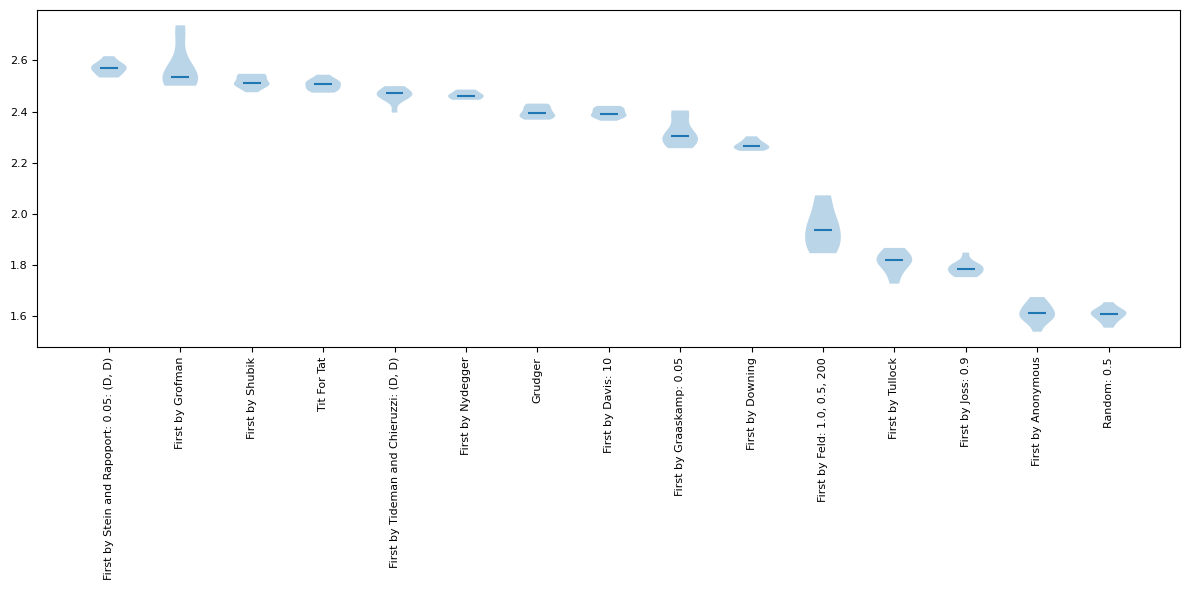

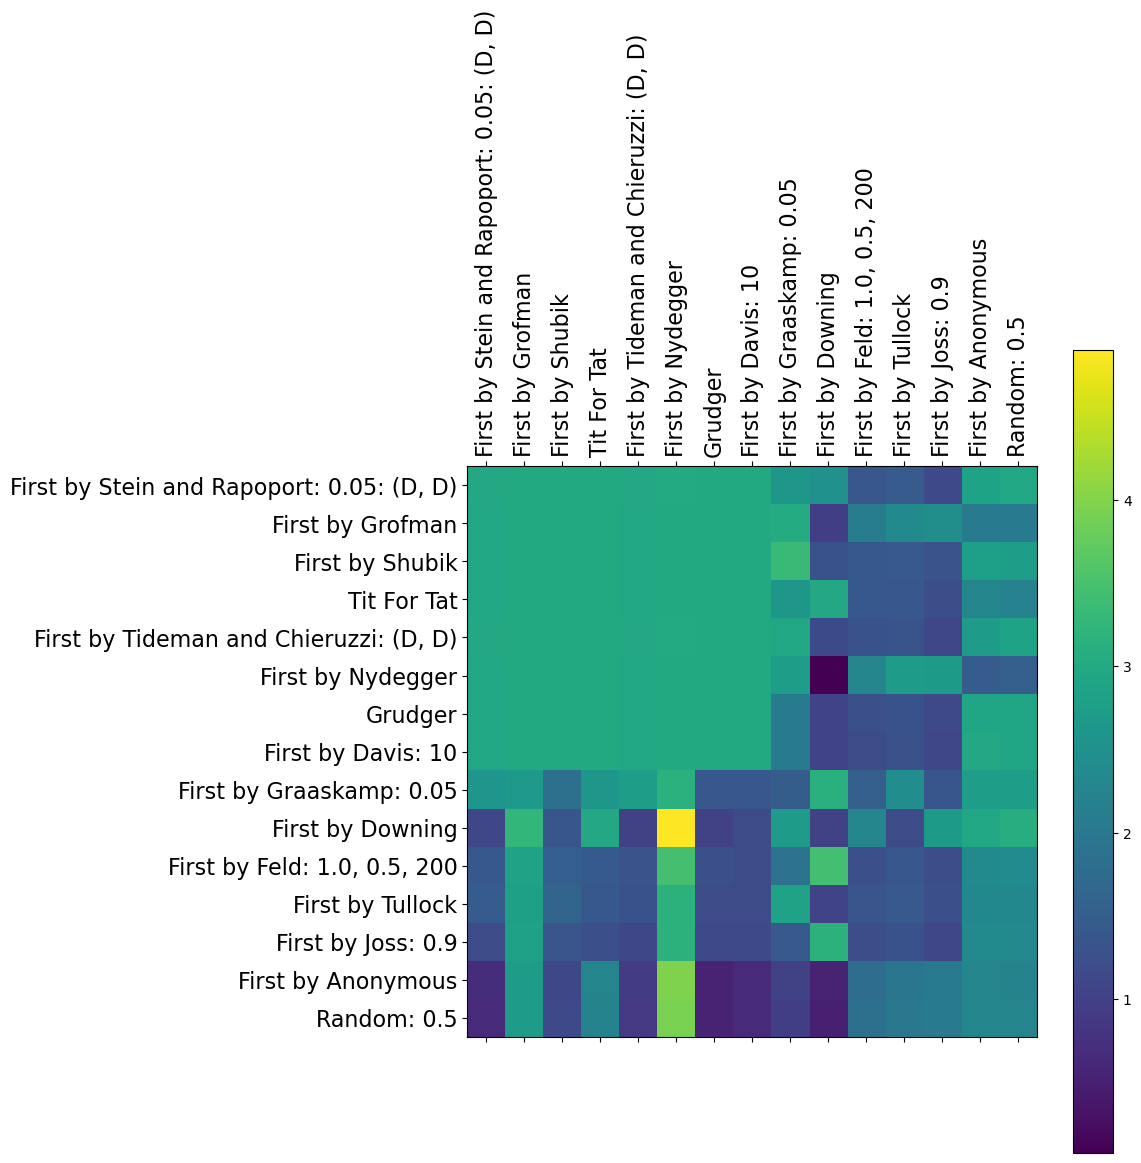

In [5]:
# Collect all the strategies played at the first tournament
strategies = [strategy() for strategy in axl.axelrod_first_strategies]
print(strategies)

tournament = axl.Tournament(strategies, 
                            turns=200,
                            repetitions=10)


results = tournament.play()
plot = axl.Plot(results)

plot.boxplot();
plot.payoff();

Notice the similarity in strategy between the high scoring strategies? They are never the first to defect, **be nice**!

### Evolutionary hawk-dove game
The hawk-dove game is a game where two birds fight over some food, where the reward of the food is V. If both birds decide to be unagressive (dove), they each get half of the food. If one of the birds decides for fight for the food (hawk), while the other bird is unaggresive, the hawk gets all the food. If both birds are aggresive, they each get half the food minus the cost (C) of fighting:

<table>
    <tr>
        <td></td>
        <td></td>
        <td>Player B</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>Dove</td>
        <td>Hawk</td>
    </tr>
    <tr>
        <td>Player A</td>
        <td>Dove</td>
        <td>(V/2, V/2)</td>
        <td>(0, V)</td>
    </tr>
    <tr>
        <td></td>
        <td>Hawk</td>
        <td>(V, 0)</td>
        <td>((V-C) / 2, (V-C) / 2)</td>
    </tr>
</table>

In this assignment we will implement an evolutionary hawk-dove game, as well as calculate the expected payoff for each strategy. 

$$
\begin{cases}
(V - C) / 2 > 0 & \text{Hawk strategy dominant}\\
(V - C) / 2 < 0 & \text{Mixed strategy!}
\end{cases}
$$

For a mixed strategy to hold the expected payoff for Hawk must be equal to Dove:
$$
E(U_D) = E(U_H)
$$

The expected payoff for dove:
$$
E(U_D) = \frac{V}{2}(1 - p_H)
$$

The expected payoff for hawk:
$$
E(U_H) = \frac{V - C}{2}p_H + V (1-p_H)
$$

Now solve:
$$
\frac{V}{2}(1 - p_H) = \frac{V - C}{2}p_H + V (1-p_H) \\ 
$$
And implement function proportion_hawk, that calculates the proportion of hawks, $p_H$, according to this equation.

Expanding and rewriting the equation above:

$$
\frac{V}{2}-\frac{V}{2}p_H=\frac{V}{2}p_H-\frac{C}{2}p_H+V-Vp_H
$$

$$
Vp_H-\frac{V}{2}p_H-\frac{V}{2}p_H+\frac{C}{2}p_H=V-\frac{V}{2}
$$

$$
p_H = \frac{V}{C}
$$

In [7]:
def proportion_hawk(V, C):
    """
    This function returns the expected number of hawks for V and C.
    """
    
    prop_hawk = V / C
    prop_hawk = np.clip(prop_hawk, 0, 1)

    return prop_hawk

In [8]:
assert isinstance(proportion_hawk(1, 2), (int, float)), "The function should return numerical (int of float) values"
assert 0 <= proportion_hawk(1, 2) <= 1, "A proportion value is always between 0 and 1!"
assert proportion_hawk(2, 1) == 1, "This is a hawk-dominant solution!"

We can test if our calculation is correct/holds in an evolutionary setting. We will test this by implementing a [Moran Process](https://axelrod.readthedocs.io/en/latest/tutorials/new_to_game_theory_and_or_python/moran.html), which is an evolutionary game, where after each round in the tournament one random individual changes its strategy based on fitness proportionate selection. Implement your  [new game](https://axelrod.readthedocs.io/en/stable/how-to/use_different_stage_games.html) based on the hawk-dove payoff, and feed it to a Moran process.

Make sure to consult the documentation of the Moran Process, to ensure you pass the correctly formated arguments. 

Hawk-dominant strategy at hawk proportion of 0.3333333333333333.


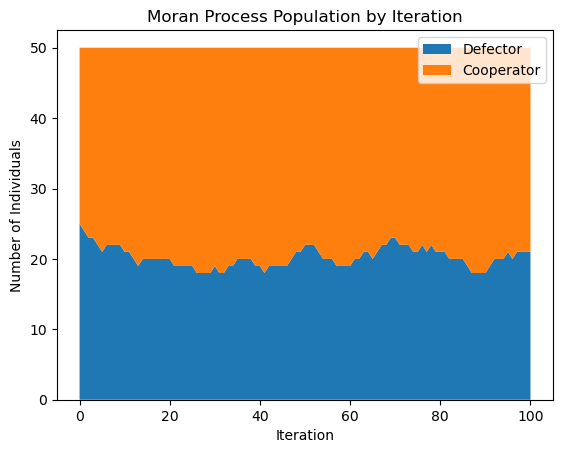

In [16]:
import matplotlib.pyplot as plt

# Set the values 
V = 1
C = 3

# Generate for instance 25 hawks (defectors) and 25 (cooperators)
print(f"Hawk-dominant strategy at hawk proportion of {proportion_hawk(V, C)}.")
n_hawks = 25
n_doves = 25
players = [axl.Defector() for _ in range(n_hawks)] + [axl.Cooperator() for _ in range(n_doves)]

# Implement a hawk dove game
hawkdove = axelrod.game.Game(r=V/2, s=0, t=V, p=(V-C)/2)

# feed the hawkdove game to the MoranProcess
mp = axl.MoranProcess(players, turns=1, game=hawkdove)

# let's see how it evolves
iters = 100
for _ in range(iters):
    if not mp.fixation_check():
        next(mp)
        
# now make a pretty plot
mp.populations_plot()
plt.show()

In [17]:
assert "players" in vars(), "store the the strategies as variable players"
assert all(type(player).__name__ in ['Cooperator', 'Defector'] for player in players), "only hawks and doves, please!"

assert "hawkdove" in vars(), "store the hawk dove ´game' as variable hawkdove"
assert type(hawkdove).__name__ == 'Game'


### Nash equilibria
Nash equilibria are equilibria where no player has anything to **gain** by changing only their own strategy. Implement the function `find_nash()`, that returns the list of nash equilibria for a payoff matrix. We already implemented the functions max_row and max_col for you, which might help in solving the assignment. 

In [18]:
def max_row(matrix, row_nr):
    """
    A helper function that returns the maximum payoff for player B given a row index
    """
    return max(x[0] for x in matrix[row_nr])

def max_col(matrix, col_nr):
    """
    A helper function that returns the maximum payoff for player A given a column index
    """
    return max(matrix[i][col_nr][1] for i in range(len(matrix)))
    
def find_nash(payoff_matrix):
    """
    Returns a list of indices [(index_player_B, index_player_A)] of the Nash-equilibria. 
    If no indices are present returns an empty list.
    """
    nash_equilibria = []
    
    for i in range(len(payoff_matrix)):
        for j in range(len(payoff_matrix[i])):
            if payoff_matrix[i][j][0] == max_row(payoff_matrix, i) and payoff_matrix[i][j][1] == max_col(payoff_matrix, j):
                nash_equilibria.append((i, j))

    return nash_equilibria

In [19]:

payoff_matrix = [[(1, 0), (0, 1)],
                 [(0, 1), (1, 0)]]
assert set(find_nash(payoff_matrix)) == set([])

payoff_matrix = [[(2, 2), (0, 0)],
                 [(0, 0), (1, 1)]]
assert set(find_nash(payoff_matrix)) == set([(0, 0), (1, 1)])

payoff_matrix = [[(0, 0), (1, 1)],
                 [(1, 1), (1, 1)]]
assert set(find_nash(payoff_matrix)) == set([(0, 1), (1, 0), (1, 1)])

payoff_matrix = [[(0, 0), (1, 1)],
                 [(1, 1), (1, 1)],
                 [(2, 2), (1, 1)]]
assert set(find_nash(payoff_matrix)) == set([(0, 1), (1, 1), (2, 0)])


### Iterated Elimination of Dominated Strategies (IEDS)
A strictly dominant strategy is a strategy that is always better than all other strategies for a player. Let's assume the following payoff table: 
<table>
    <tr>
        <td></td>
        <td></td>
        <td>Player B</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>C</td>
        <td>**D**</td>
    </tr>
    <tr>
        <td>Player A</td>
        <td>C</td>
        <td>(2, 1)</td>
        <td>**(1, 4)**</td>
    </tr>
    <tr>
        <td></td>
        <td>D</td>
        <td>(1, 2)</td>
        <td>**(2, 3)**</td>
    </tr>
</table>
For player A it is unclear whether to play Cooperate or Defect, since it depends on the strategy of the other player which is best. However, for player B it is always better to defect, since those rewards are always higher than the cooperation scores. We say that Cooperation is a (strictly) dominated rule, we can therefore ignore this row in the game (under the assumption that the player is purely rational):
<table>
    <tr>
        <td></td>
        <td></td>
        <td>Player B</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td>D</td>
    </tr>
    <tr>
        <td>Player A</td>
        <td>C</td>
        <td></td>
        <td>(1, 4)</td>
    </tr>
    <tr>
        <td></td>
        <td>**D**</td>
        <td></td>
        <td>**(2, 3)**</td>
    </tr>
</table>
Since player A knows the payoff for player B, it knows that player B will always play Defect. Using this knowledge, it is obvious for player A that Defection always has a higher reward than Cooperation (Cooperation is dominated by Defect). We can therefore also ignore the Cooperation column for player A. Now we end up with a simple table with one **dominant** option:
<table>
    <tr>
        <td></td>
        <td></td>
        <td>Player B</td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td></td>
        <td>D</td>
    </tr>
    <tr>
        <td>Player A</td>
        <td></td>
        <td></td>
        <td></td>
    </tr>
    <tr>
        <td></td>
        <td>D</td>
        <td></td>
        <td>(2, 3)</td>
    </tr>
</table>
Rational players will always always play defect with the original payoff matrix.

In the next assignment we will implement the Iterated Elimination of Dominated Strategies algorithm (only pure strategies). The algorithm works by iteratively removing dominated strategies, just like we did in the example. You only have to remove **strictly dominated** strategies! We already implemented the functions `remove_row()` and `remove_col()` for you, which might help in solving the assignment.

In [ ]:
import copy

def remove_row(matrix, row_nr):
    """
    A helper function that deletes a row by its index
    """
    del matrix[row_nr]
    
def remove_col(matrix, col_nr):
    """
    A helper function that deletes a column by its index
    """
    for row_i in range(len(matrix)):
        del matrix[row_i][col_nr]


def IEDS(payoff_matrix):
    """
    The Iterated Elimination of Dominated Strategies algorithm. 
    Returns the smallest subset of non-dominated strategies
    """
    matrix = copy.deepcopy(payoff_matrix)
    # YOUR CODE HERE
    raise NotImplementedError()
    return matrix    

In [ ]:
payoff_matrix = [[(1, 1)]]
assert IEDS(payoff_matrix) == [[(1, 1)]]

payoff_matrix = [[(2, 2)],
                 [(1, 1)],
                 [(7, 1)],
                 [(1, 2)]]
assert IEDS(payoff_matrix) == [[(7, 1)]]

payoff_matrix = [[(2, 2), (1, 1)],
                 [(1, 1), (0, 0)]]
assert IEDS(payoff_matrix) == [[(2, 2)]]

payoff_matrix = [[(3, 1), (0, 1), (0, 0)],
                 [(1, 1), (1, 1), (5, 0)],
                 [(0, 1), (4, 1), (0, 0)]]
assert IEDS(payoff_matrix) == [[(3, 1), (0, 1)], 
                               [(1, 1), (1, 1)], 
                               [(0, 1), (4, 1)]]


### Bonus: Spatial prisonners dilemma
The module axelrod has a built-in option for spatial tournaments, see [here](https://axelrod.readthedocs.io/en/stable/how-to/create_spatial_tournaments.html). Or you could easily combine it with mesa! Take a look at the folder mesa_axelrod for a very simple example, where there are agents walking around randomly, and playing iterated prisonners dilemma. Winners reproduce, and losers die. 